<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Comparativa/red_neuronal_densa_anual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import RMSprop

In [4]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modo_1["Fecha"] = pd.to_datetime(modo_1["Fecha"],format='%Y-%m-%d')
modo_2["Fecha"] = pd.to_datetime(modo_2["Fecha"],format='%Y-%m-%d')
modo_3["Fecha"] = pd.to_datetime(modo_3["Fecha"],format='%Y-%m-%d')
modo_4["Fecha"] = pd.to_datetime(modo_4["Fecha"],format='%Y-%m-%d')
modo_5["Fecha"] = pd.to_datetime(modo_5["Fecha"],format='%Y-%m-%d')
residuo["Fecha"] = pd.to_datetime(residuo["Fecha"],format='%Y-%m-%d')
modo_1.set_index("Fecha", inplace=True)
modo_2.set_index("Fecha", inplace=True)
modo_3.set_index("Fecha", inplace=True)
modo_4.set_index("Fecha", inplace=True)
modo_5.set_index("Fecha", inplace=True)
residuo.set_index("Fecha", inplace=True)

In [5]:
modo_1 = modo_1.asfreq('D')
modo_2 = modo_2.asfreq('D')
modo_3 = modo_3.asfreq('D')
modo_4 = modo_4.asfreq('D')
modo_5 = modo_5.asfreq('D')
residuo = residuo.asfreq('D')
modo_1.interpolate(inplace=True)
modo_2.interpolate(inplace=True)
modo_3.interpolate(inplace=True)
modo_4.interpolate(inplace=True)
modo_5.interpolate(inplace=True)
residuo.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

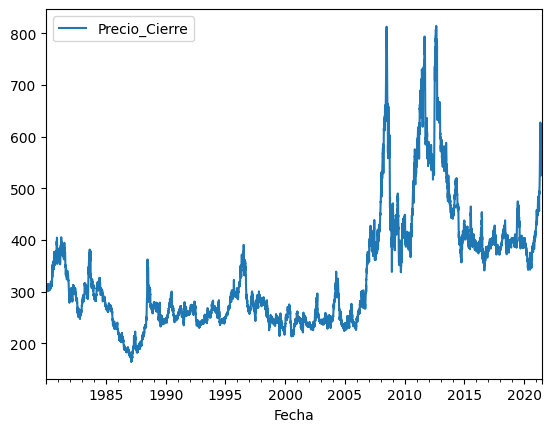

In [6]:
datos_emd = modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd.plot()

In [7]:
datos_emd.describe()

,Precio_Cierre
count,15155.000000
mean,334.254726
std,115.387240
min,164.250000
25%,249.000000
50%,290.250000
75%,395.000000
max,814.500000


In [8]:
def  create_features ( df ):
    """
    Crea características de series de tiempo basadas en el índice de series de tiempo.
    """
    df = df.copy()
    df[ 'diasemana' ] = df.index.dayofweek
    df[ 'trimestre' ] = df.index.quarter
    df[ 'mes' ] = df.index.month
    df[ 'año' ] = df.index.year
    df[ 'diadelaño' ] = df.index.dayofyear
    df[ 'diadelmes' ] = df.index.day
    df[ 'semanadelaño' ] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['Precio_Cierre'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df

In [9]:
import optuna
from keras.optimizers import RMSprop

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 10, 70), input_shape=(1,10))) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(Dense(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh')) # Capas ocultas con unidades variables
    model.add(Flatten())
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

# Modelamos Modo 1

In [10]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = create_features(modo_1_escalado)
modo_1_sup = add_lags(modo_1_sup)
modo_1_sup.dropna(inplace=True)
modo_1_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.008587,5,1,1,1983,1,1,52,-0.017960,0.032107,-0.111422
1983-01-02,-0.001436,6,1,1,1983,2,2,52,-0.002733,0.032931,0.026287
1983-01-03,0.005715,0,1,1,1983,3,3,1,0.012495,0.007644,0.153734
1983-01-04,-0.025920,1,1,1,1983,4,4,1,0.027722,-0.017644,0.119612
1983-01-05,0.020131,2,1,1,1983,5,5,1,-0.045003,-0.042931,0.085490


In [11]:
modo_1= pd.DataFrame(modo_1_scaler.inverse_transform(modo_1_sup),columns=modo_1_sup.columns,index=modo_1_sup.index)

In [12]:
total_datos=len(modo_1_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values.astype('float32')
datos_validacion_m1_values = datos_validacion_m1.values.astype('float32')
datos_testeo_m1_values = datos_testeo_m1.values.astype('float32')

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


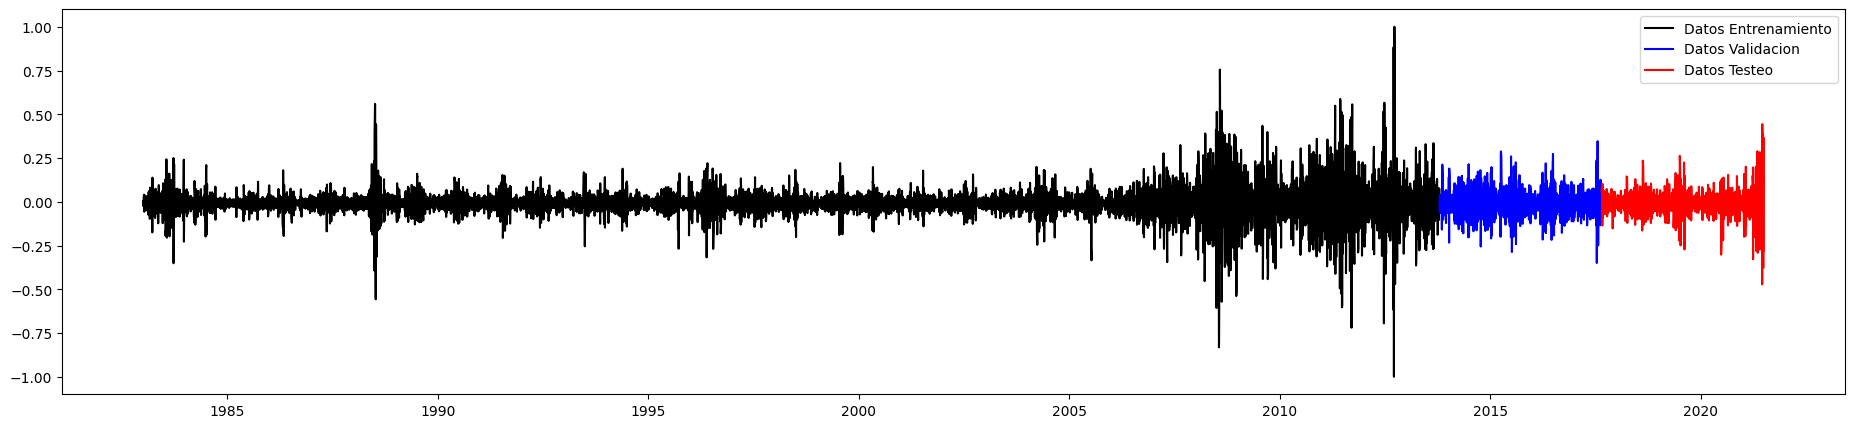

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [14]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [15]:
def modeloRD_m1():
  modelo = Sequential()
  modelo.add(Dense(units=62, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=15,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0004), loss='mse')
  return modelo

In [16]:
modelo = modeloRD_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 7s 3ms/step - loss: 0.0152
Epoch 2/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0059
Epoch 3/40
1607/1607 [==============================] - 7s 5ms/step - loss: 0.0055
Epoch 4/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0054
Epoch 5/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0054
Epoch 6/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0053
Epoch 8/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0053
Epoch 9/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0053
Epoch 10/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0053
Epoch 11/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 12/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0053
E

In [17]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


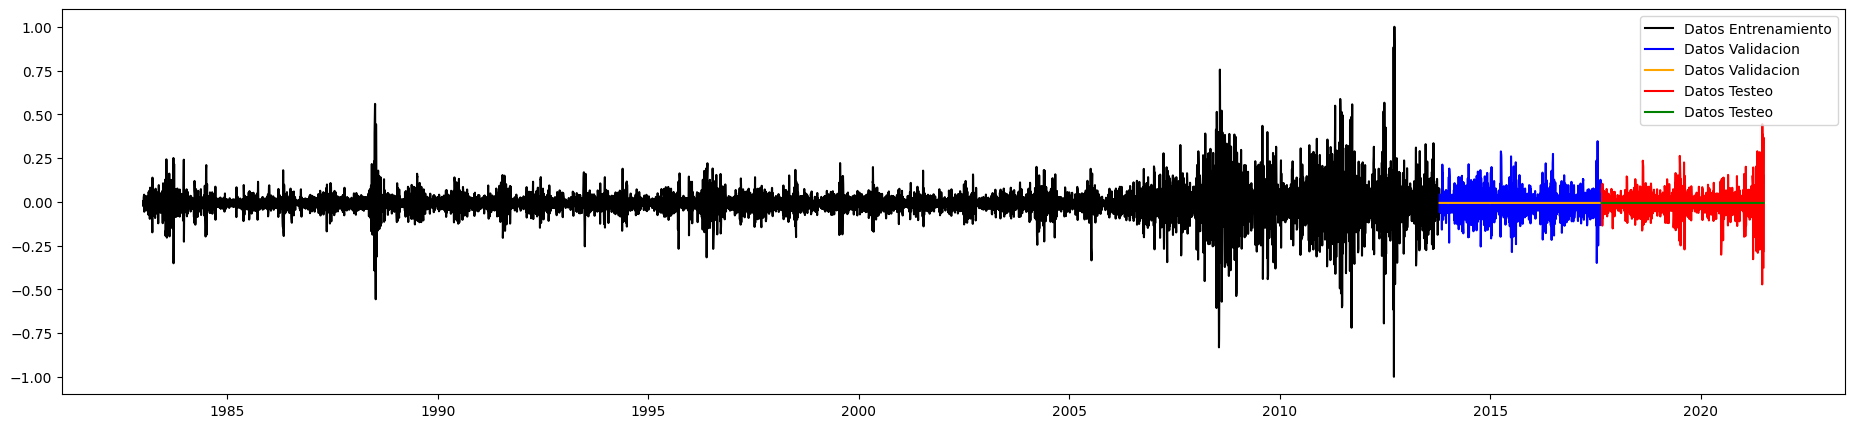

In [18]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.Precio_Cierre))
print(score)

0.0778987


In [83]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

# Modelamos modo 2


In [20]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = create_features(modo_2_escalado)
modo_2_sup = add_lags(modo_2_sup)
modo_2_sup.dropna(inplace=True)
modo_2_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.188319,5,1,1,1983,1,1,52,0.167714,0.222971,0.307612
1983-01-02,0.180620,6,1,1,1983,2,2,52,0.160417,0.253188,0.237516
1983-01-03,0.172921,0,1,1,1983,3,3,1,0.153120,0.265889,0.166993
1983-01-04,0.148923,1,1,1,1983,4,4,1,0.145822,0.278589,0.154927
1983-01-05,0.130999,2,1,1,1983,5,5,1,0.157503,0.291290,0.142860


In [21]:
modo_2= pd.DataFrame(modo_2_scaler.inverse_transform(modo_2_sup),columns=modo_2_sup.columns,index=modo_2_sup.index)


In [22]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values.astype('float32')
datos_validacion_m2_values = datos_validacion_m2.values.astype('float32')
datos_testeo_m2_values = datos_testeo_m2.values.astype('float32')

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


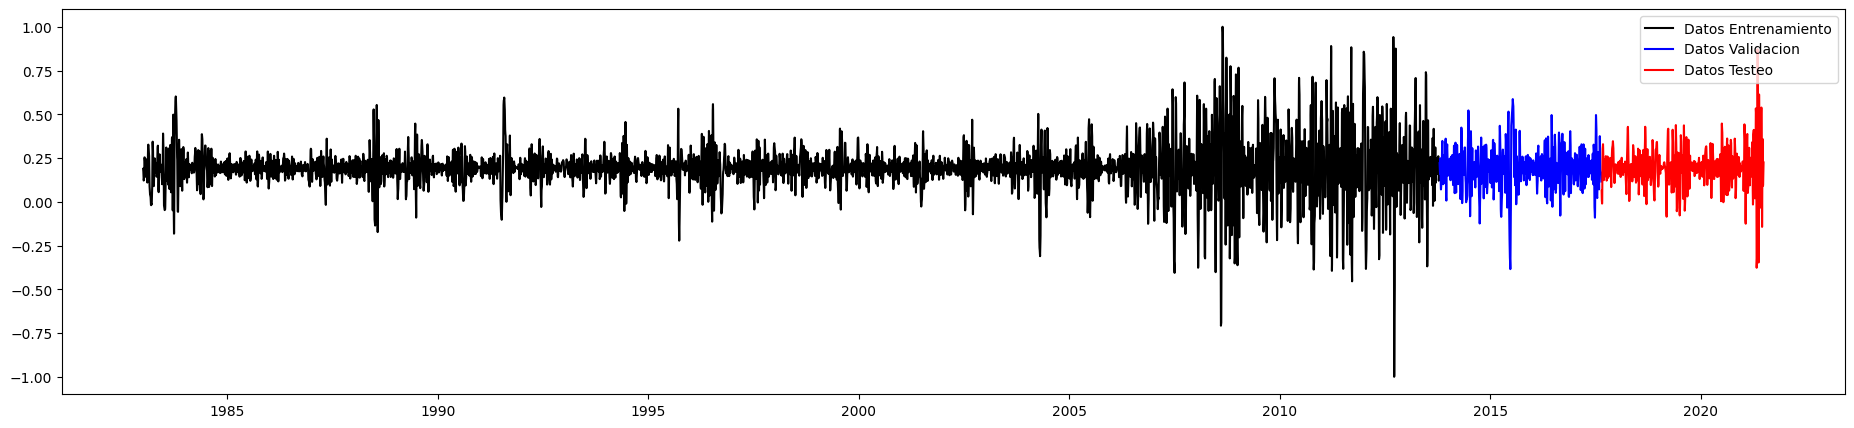

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [24]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [27]:
def modeloRD_m2():
  modelo = Sequential()
  modelo.add(Dense(units=45, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=26,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.000118), loss='mse')
  return modelo

In [28]:
modelo = modeloRD_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0369
Epoch 2/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 3/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 4/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0121
Epoch 5/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 6/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0120
Epoch 8/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 9/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0121
Epoch 10/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 11/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0120
Epoch 12/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0120
E

In [29]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


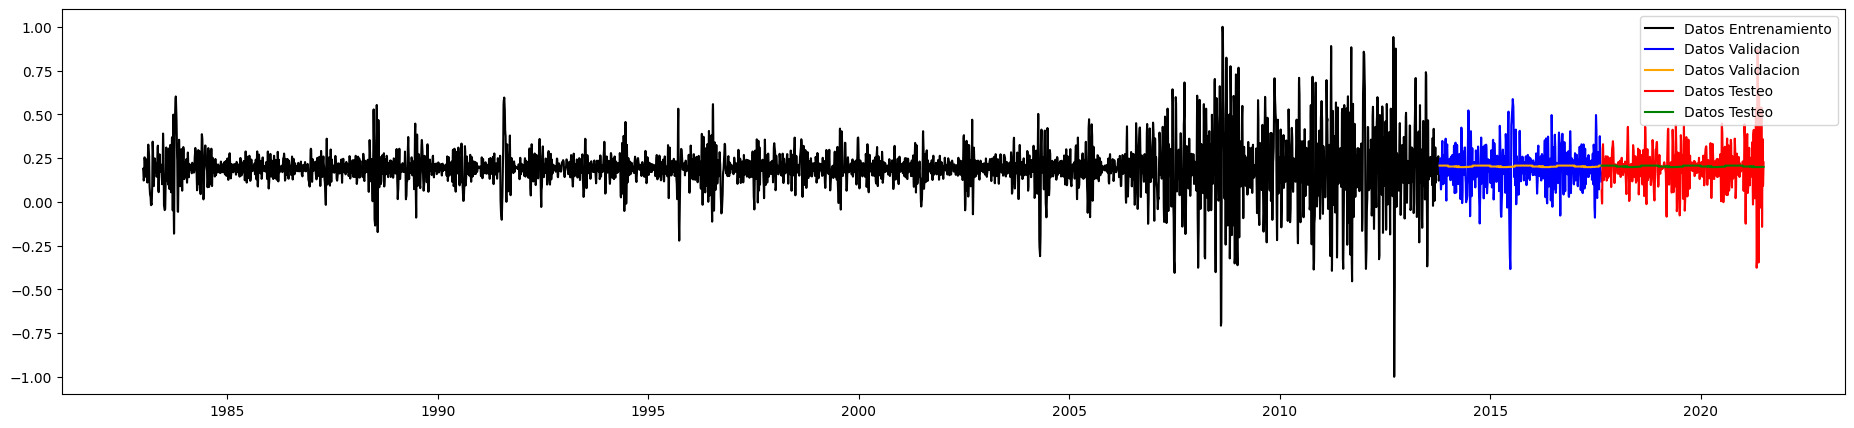

In [30]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [31]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.Precio_Cierre))
print(score)

0.11776678


In [32]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

In [84]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos modo 3

In [34]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = create_features(modo_3_escalado)
modo_3_sup = add_lags(modo_3_sup)
modo_3_sup.dropna(inplace=True)
modo_3_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.140801,5,1,1,1983,1,1,52,0.193082,0.059190,0.151156
1983-01-02,0.143270,6,1,1,1983,2,2,52,0.193951,0.067364,0.128091
1983-01-03,0.145740,0,1,1,1983,3,3,1,0.194819,0.073162,0.106627
1983-01-04,0.155028,1,1,1,1983,4,4,1,0.195688,0.078961,0.102951
1983-01-05,0.163749,2,1,1,1983,5,5,1,0.190044,0.084759,0.099274


In [35]:
modo_3= pd.DataFrame(modo_3_scaler.inverse_transform(modo_3_sup),columns=modo_3_sup.columns,index=modo_3_sup.index)

In [36]:
total_datos=len(modo_3_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

datos_entrenamiento_m3_values= datos_entrenamiento_m3.values.astype('float32')
datos_validacion_m3_values = datos_validacion_m3.values.astype('float32')
datos_testeo_m3_values = datos_testeo_m3.values.astype('float32')

X_train, y_train = datos_entrenamiento_m3_values[:, :-1], datos_entrenamiento_m3_values[:, -1]
X_val, y_val = datos_validacion_m3_values[:, :-1], datos_validacion_m3_values[:, -1]
X_test, y_test = datos_testeo_m3_values[:, :-1], datos_testeo_m3_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


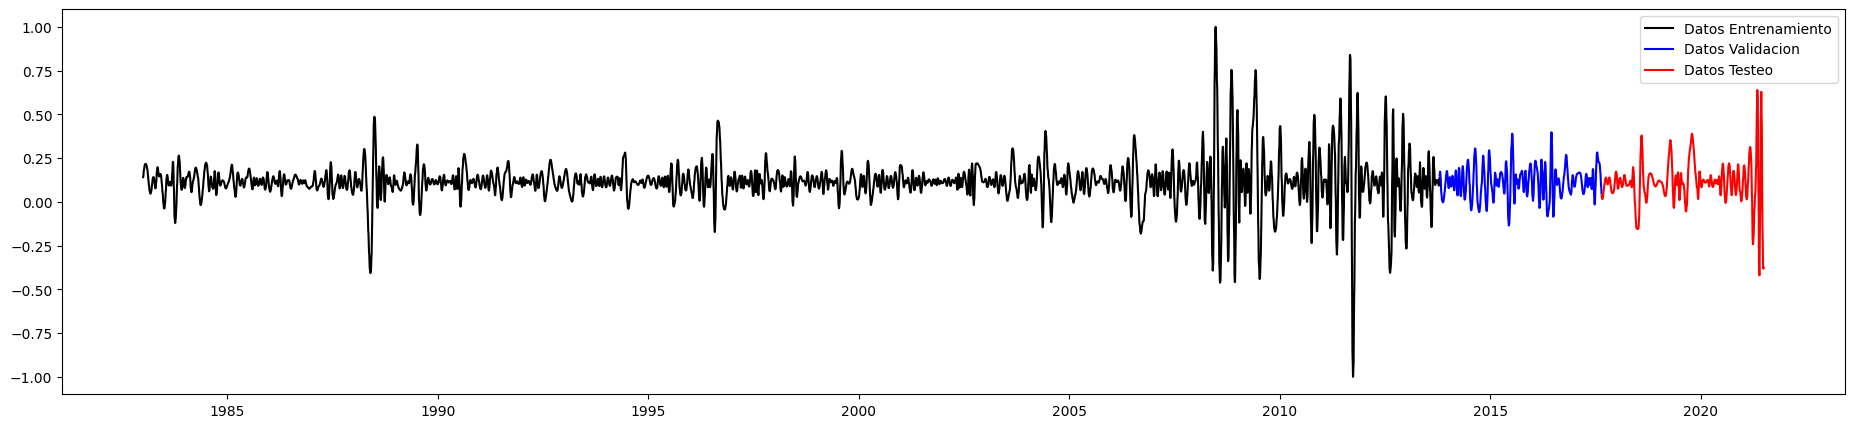

In [37]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [38]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [40]:
def modeloRD_m3():
  modelo = Sequential()
  modelo.add(Dense(units=24, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=25, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.00019), loss='mse')
  return modelo

In [41]:
modelo = modeloRD_m3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0130
Epoch 2/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 3/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0112
Epoch 4/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0112
Epoch 5/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 6/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 8/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0112
Epoch 9/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0112
Epoch 10/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 11/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 12/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0112
E

In [42]:
prediccion_validacion_m3 = modelo.predict(X_val)
prediccion_testeo_m3 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


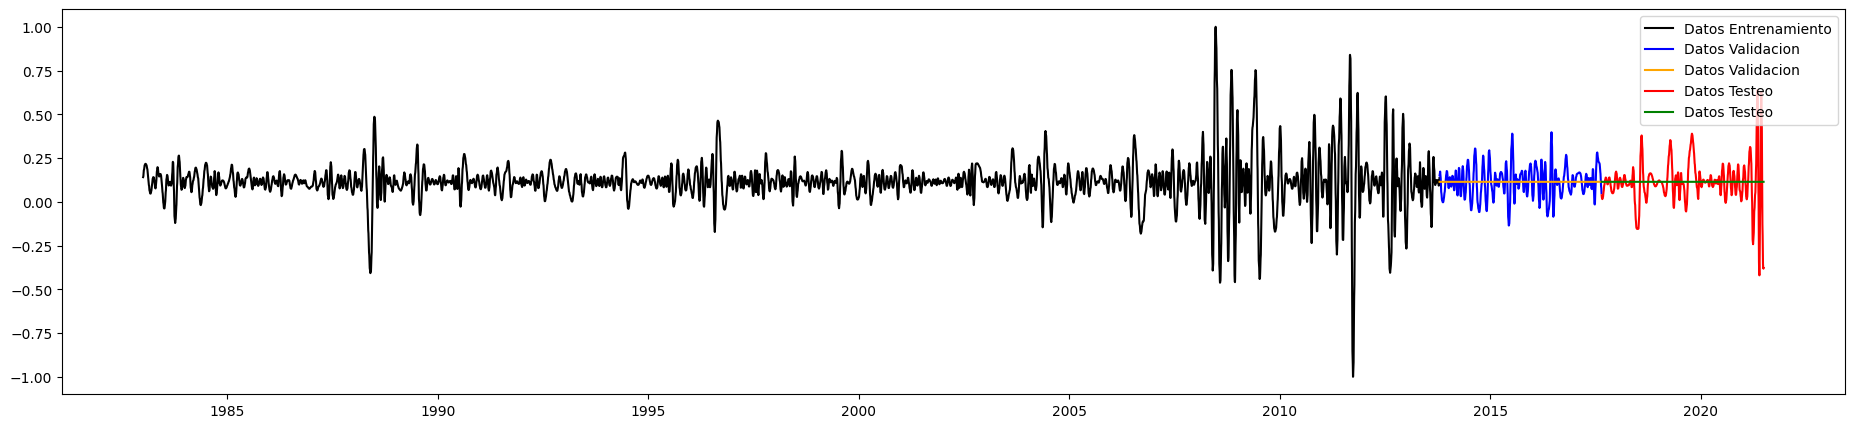

In [43]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m3.index,prediccion_validacion_m3,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m3.index,prediccion_testeo_m3,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [44]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m3,datos_validacion_m3.Precio_Cierre))
print(score)

0.087603465


In [45]:
prediccion_validacion_m3 = modo_3_scaler.inverse_transform(prediccion_validacion_m3)
prediccion_testeo_m3 = modo_3_scaler.inverse_transform(prediccion_testeo_m3 )

# modelamos modo 4


In [46]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = create_features(modo_4_escalado)
modo_4_sup = add_lags(modo_4_sup)
modo_4_sup.dropna(inplace=True)
modo_4_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.086861,5,1,1,1983,1,1,52,-0.049781,-0.074277,-0.039828
1983-01-02,0.087461,6,1,1,1983,2,2,52,-0.048311,-0.073692,-0.046625
1983-01-03,0.088060,0,1,1,1983,3,3,1,-0.046842,-0.073162,-0.052982
1983-01-04,0.090320,1,1,1,1983,4,4,1,-0.045372,-0.072632,-0.054141
1983-01-05,0.092455,2,1,1,1983,5,5,1,-0.039134,-0.072102,-0.055300


In [47]:
modo_4= pd.DataFrame(modo_4_scaler.inverse_transform(modo_4_sup),columns=modo_4_sup.columns,index=modo_4_sup.index)


In [48]:
total_datos=len(modo_4_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

datos_entrenamiento_m4_values= datos_entrenamiento_m4.values.astype('float32')
datos_validacion_m4_values = datos_validacion_m4.values.astype('float32')
datos_testeo_m4_values = datos_testeo_m4.values.astype('float32')

X_train, y_train = datos_entrenamiento_m4_values[:, :-1], datos_entrenamiento_m4_values[:, -1]
X_val, y_val = datos_validacion_m4_values[:, :-1], datos_validacion_m4_values[:, -1]
X_test, y_test = datos_testeo_m4_values[:, :-1], datos_testeo_m4_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


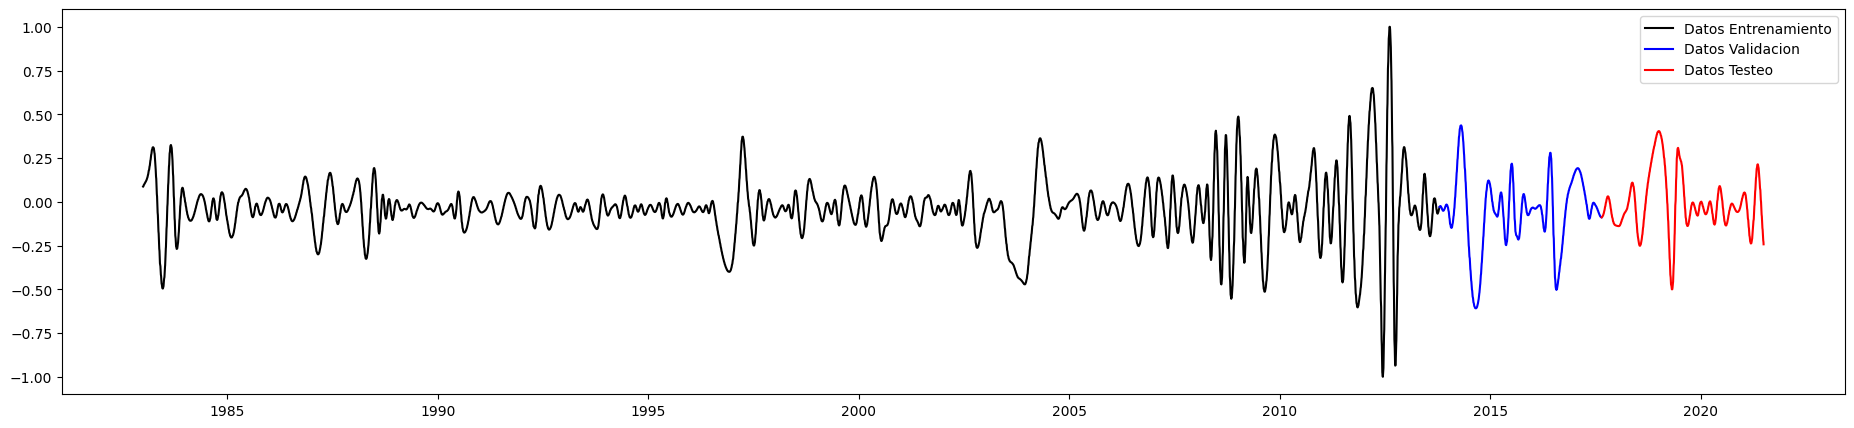

In [49]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [50]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [51]:
def modeloRD_m4():
  modelo = Sequential()
  modelo.add(Dense(units=42, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=37, activation='tanh'))
  modelo.add(Dense(units=10, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.00417), loss='mse')
  return modelo


In [52]:
modelo = modeloRD_m4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0203
Epoch 2/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0180
Epoch 3/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.0180
Epoch 4/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0181
Epoch 5/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0180
Epoch 6/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0181
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0182
Epoch 8/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0179
Epoch 9/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0180
Epoch 10/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0181
Epoch 11/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0179
Epoch 12/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0179
E

In [53]:
modelo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 42)             462       
                                                                 
 dense_10 (Dense)            (None, 1, 37)             1591      
                                                                 
 dense_11 (Dense)            (None, 1, 10)             380       
                                                                 
 flatten_3 (Flatten)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2444 (9.55 KB)
Trainable params: 2444 (9.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
prediccion_validacion_m4 = modelo.predict(X_val)
prediccion_testeo_m4 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


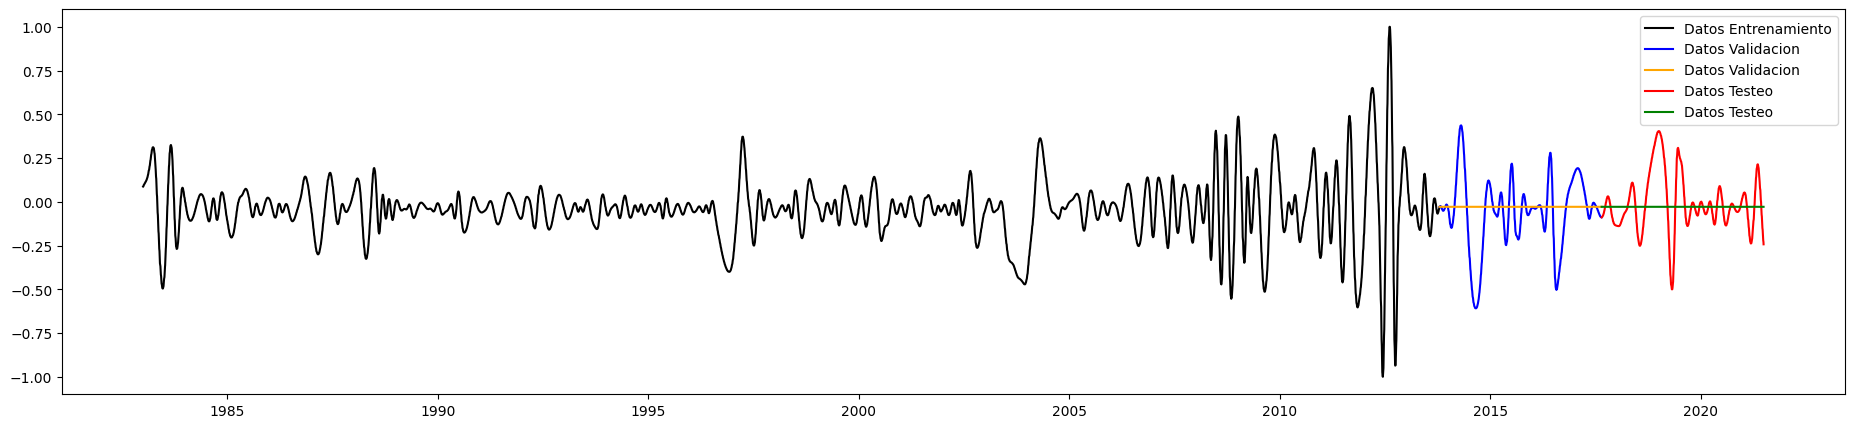

In [55]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m4.index,prediccion_validacion_m4,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m4.index,prediccion_testeo_m4,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [56]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m4,datos_validacion_m4.Precio_Cierre))
print(score)

0.21087837


In [57]:
prediccion_validacion_m4 = modo_4_scaler.inverse_transform(prediccion_validacion_m4)
prediccion_testeo_m4 = modo_4_scaler.inverse_transform(prediccion_testeo_m4 )

# Modelamos modo 5

In [58]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = create_features(modo_5_escalado)
modo_5_sup = add_lags(modo_5_sup)
modo_5_sup.dropna(inplace=True)
modo_5_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.211661,5,1,1,1983,1,1,52,-0.112336,-0.048832,0.106591
1983-01-02,-0.211620,6,1,1,1983,2,2,52,-0.111756,-0.049922,0.104982
1983-01-03,-0.211579,0,1,1,1983,3,3,1,-0.111176,-0.050620,0.103360
1983-01-04,-0.211387,1,1,1,1983,4,4,1,-0.110596,-0.051317,0.103032
1983-01-05,-0.211167,2,1,1,1983,5,5,1,-0.108179,-0.052015,0.102705


In [59]:
modo_5= pd.DataFrame(modo_5_scaler.inverse_transform(modo_5_sup),columns=modo_5_sup.columns,index=modo_5_sup.index)


In [60]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values.astype('float32')
datos_validacion_m5_values = datos_validacion_m5.values.astype('float32')
datos_testeo_m5_values = datos_testeo_m5.values.astype('float32')

X_train, y_train = datos_entrenamiento_m5_values[:, :-1], datos_entrenamiento_m5_values[:, -1]
X_val, y_val = datos_validacion_m5_values[:, :-1], datos_validacion_m5_values[:, -1]
X_test, y_test = datos_testeo_m5_values[:, :-1], datos_testeo_m5_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


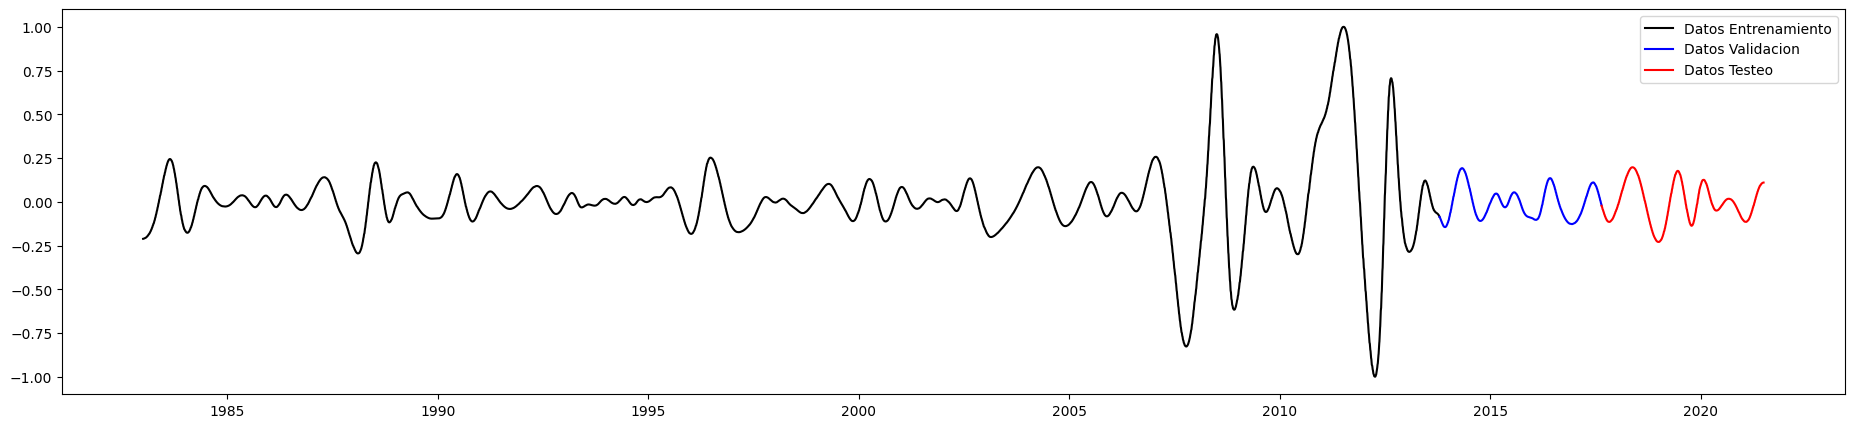

In [61]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [62]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [63]:
def modeloRD_m5():
  modelo = Sequential()
  modelo.add(Dense(units=16, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=47, activation='tanh'))
  modelo.add(Dense(units=12, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.013), loss='mse')
  return modelo

In [64]:
modelo = modeloRD_m5()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0473
Epoch 2/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0364
Epoch 3/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0365
Epoch 4/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0361
Epoch 5/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0356
Epoch 6/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0362
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0411
Epoch 8/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.0341
Epoch 9/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0338
Epoch 10/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0338
Epoch 11/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0329
Epoch 12/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.0339
E

In [65]:
prediccion_validacion_m5 = modelo.predict(X_val)
prediccion_testeo_m5 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


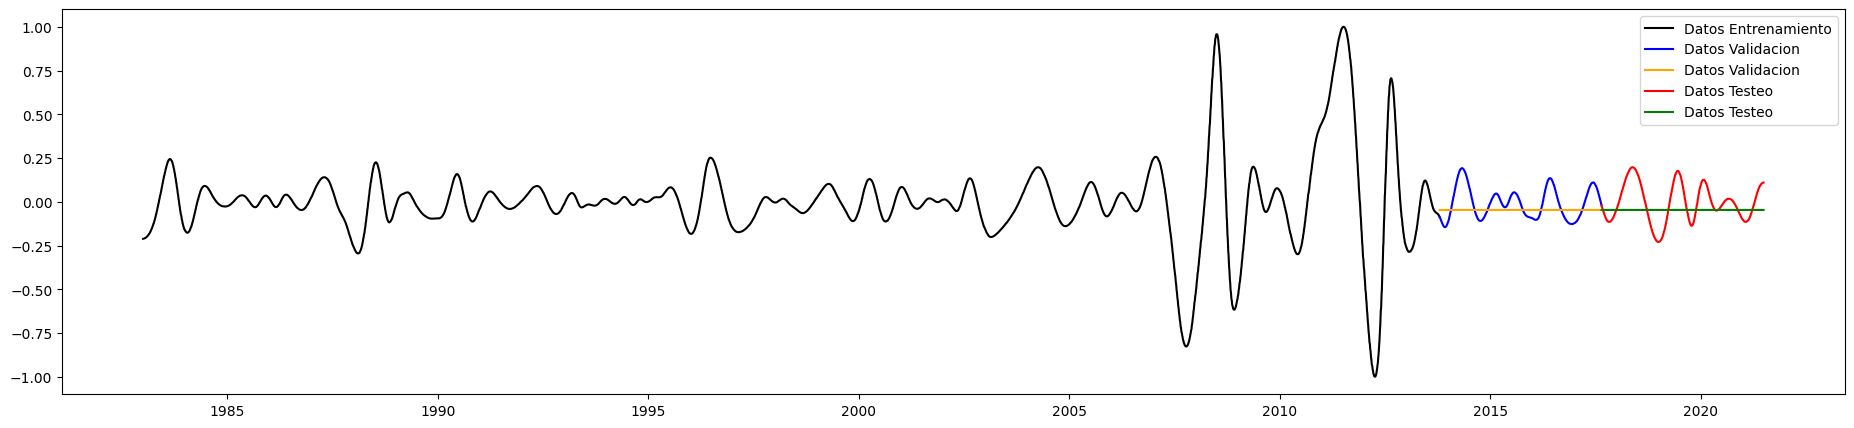

In [66]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,prediccion_validacion_m5,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_testeo_m5,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [67]:
prediccion_validacion_m5 = modo_5_scaler.inverse_transform(prediccion_validacion_m5)
prediccion_testeo_m5 = modo_5_scaler.inverse_transform(prediccion_testeo_m5 )

# Modelamos Residuo

In [68]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = create_features(residuo_escalado)
residuo_sup = add_lags(residuo_sup)
residuo_sup.dropna(inplace=True)
residuo_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.521621,5,1,1,1983,1,1,52,-0.458435,-0.175241,-0.500525
1983-01-02,-0.521433,6,1,1,1983,2,2,52,-0.458852,-0.174871,-0.499712
1983-01-03,-0.521244,0,1,1,1983,3,3,1,-0.459269,-0.174631,-0.498891
1983-01-04,-0.520489,1,1,1,1983,4,4,1,-0.459687,-0.174390,-0.498725
1983-01-05,-0.519731,2,1,1,1983,5,5,1,-0.461346,-0.174149,-0.498560


In [69]:
residuo = pd.DataFrame(residuo_scaler.inverse_transform(residuo_sup),columns=residuo_sup.columns,index=residuo_sup.index)

In [70]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values.astype('float32')
datos_validacion_residuo_values = datos_validacion_residuo.values.astype('float32')
datos_testeo_residuo_values = datos_testeo_residuo.values.astype('float32')

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


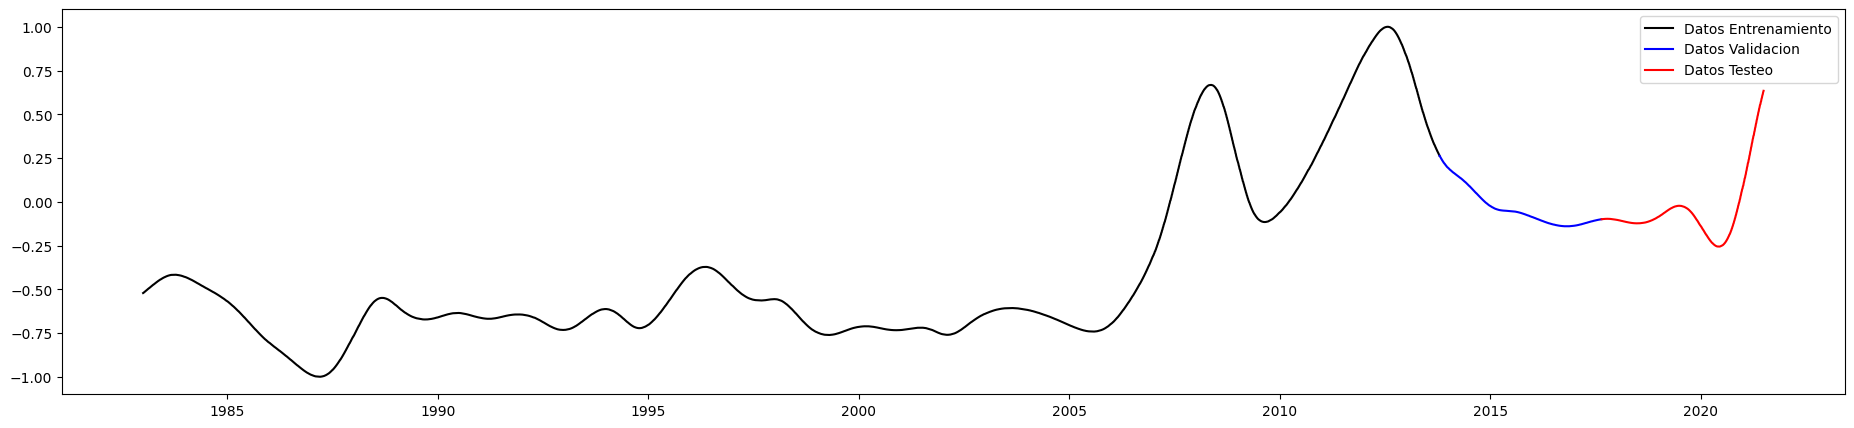

In [71]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [72]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-05-22 20:21:32,243] A new study created in memory with name: no-name-1e1b1a79-e7c2-42c5-a267-483b3f3fca96


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:21:39,805] Trial 0 finished with value: 1.9393972158432007 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.04486199318484797}. Best is trial 0 with value: 1.9393972158432007.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:21:48,880] Trial 1 finished with value: 0.09384190291166306 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.017933309351263922}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:22:00,275] Trial 2 finished with value: 15.949332237243652 and parameters: {'units': 28, 'n_layers': 2, 'units_0': 30, 'units_1': 59, 'learning_rate': 0.09564606602459554}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:22:08,309] Trial 3 finished with value: 0.10569359362125397 and parameters: {'units': 67, 'n_layers': 2, 'units_0': 68, 'units_1': 57, 'learning_rate': 0.021227893662915703}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:22:19,759] Trial 4 finished with value: 19.317834854125977 and parameters: {'units': 41, 'n_layers': 2, 'units_0': 34, 'units_1': 66, 'learning_rate': 0.08758323393720015}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:22:28,933] Trial 5 finished with value: 3.2481002807617188 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 51, 'units_1': 25, 'learning_rate': 0.06886784449241415}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:22:36,808] Trial 6 finished with value: 0.26958194375038147 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 67, 'units_1': 38, 'learning_rate': 0.04571401787219981}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:22:48,156] Trial 7 finished with value: 0.38048943877220154 and parameters: {'units': 35, 'n_layers': 2, 'units_0': 39, 'units_1': 30, 'learning_rate': 0.06286091253310289}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:22:56,531] Trial 8 finished with value: 1.5674694776535034 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 22, 'units_1': 10, 'learning_rate': 0.08465283215316963}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:23:08,017] Trial 9 finished with value: 12.693559646606445 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.07065317889467386}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:23:16,757] Trial 10 finished with value: 1.2520149946212769 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.0048363973951273745}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:23:24,173] Trial 11 finished with value: 1.0059221982955933 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.01563806213727572}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:23:32,984] Trial 12 finished with value: 3.796841621398926 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.026234671796699936}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:23:40,832] Trial 13 finished with value: 0.21977965533733368 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.02941936639458631}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:23:49,757] Trial 14 finished with value: 0.9287351369857788 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 61, 'units_1': 55, 'learning_rate': 0.0023477629144930054}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:23:59,343] Trial 15 finished with value: 0.12619689106941223 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.030571570973390312}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:24:06,936] Trial 16 finished with value: 1.2036821842193604 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.01673568604143448}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:24:16,527] Trial 17 finished with value: 0.1708502620458603 and parameters: {'units': 63, 'n_layers': 2, 'units_0': 46, 'units_1': 48, 'learning_rate': 0.03872058599454088}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:24:24,658] Trial 18 finished with value: 1.7744380235671997 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.015816468423951284}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:24:33,633] Trial 19 finished with value: 5.3397369384765625 and parameters: {'units': 34, 'n_layers': 2, 'units_0': 24, 'units_1': 70, 'learning_rate': 0.05555348633125935}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:24:44,868] Trial 20 finished with value: 1.382676362991333 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.022427492580387877}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:24:56,040] Trial 21 finished with value: 0.12315109372138977 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.03697202429968414}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:25:03,466] Trial 22 finished with value: 0.11660334467887878 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.03681136902204979}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:25:14,712] Trial 23 finished with value: 1.734461784362793 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.00688595565342905}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:25:23,154] Trial 24 finished with value: 0.7938252687454224 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.03611886574006189}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:25:30,985] Trial 25 finished with value: 1.2832589149475098 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.01973612010457071}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:25:42,448] Trial 26 finished with value: 1.5129568576812744 and parameters: {'units': 34, 'n_layers': 2, 'units_0': 53, 'units_1': 48, 'learning_rate': 0.010019137563088545}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:25:50,125] Trial 27 finished with value: 12.066011428833008 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.051698427853242364}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:25:59,071] Trial 28 finished with value: 2.0247960090637207 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 70, 'units_1': 20, 'learning_rate': 0.033746370074751245}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:26:07,525] Trial 29 finished with value: 2.338263988494873 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.047278094162044246}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:26:15,068] Trial 30 finished with value: 4.926055431365967 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.04180215131092393}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:26:24,024] Trial 31 finished with value: 3.422544240951538 and parameters: {'units': 66, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.02896439345975939}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:26:35,340] Trial 32 finished with value: 1.7315672636032104 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.011553043373586171}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:26:42,996] Trial 33 finished with value: 0.09452717751264572 and parameters: {'units': 66, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.021210940970743476}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:26:54,222] Trial 34 finished with value: 1.0718568563461304 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.0240218287343052}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:27:05,467] Trial 35 finished with value: 0.7479363679885864 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.0222765960840979}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:27:13,855] Trial 36 finished with value: 1.235606074333191 and parameters: {'units': 60, 'n_layers': 2, 'units_0': 65, 'units_1': 41, 'learning_rate': 0.00043384781924734814}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:27:23,616] Trial 37 finished with value: 0.8957298994064331 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 61, 'units_1': 59, 'learning_rate': 0.017876198252780306}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:27:34,918] Trial 38 finished with value: 0.7377110123634338 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.01176004683514685}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:27:46,381] Trial 39 finished with value: 4.951778411865234 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 56, 'units_1': 36, 'learning_rate': 0.0582488371472978}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:27:54,010] Trial 40 finished with value: 3.7477660179138184 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.0431520510286854}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:28:05,291] Trial 41 finished with value: 1.5815811157226562 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.03493185063247998}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:28:16,593] Trial 42 finished with value: 0.45186731219291687 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.03940906984291643}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:28:27,919] Trial 43 finished with value: 0.3828732669353485 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.028944747860378282}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:28:39,232] Trial 44 finished with value: 0.23108986020088196 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.07187465873921187}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:28:47,193] Trial 45 finished with value: 27.250499725341797 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.09987052450729253}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:28:58,463] Trial 46 finished with value: 0.535861074924469 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.025314774939478653}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:29:09,737] Trial 47 finished with value: 7.585671424865723 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.04845539040993611}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:29:17,725] Trial 48 finished with value: 1.6555720567703247 and parameters: {'units': 63, 'n_layers': 2, 'units_0': 45, 'units_1': 49, 'learning_rate': 0.032308811088824683}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:29:26,662] Trial 49 finished with value: 2.0603058338165283 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.013401650978547253}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:29:34,372] Trial 50 finished with value: 1.3394033908843994 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0066706487527226285}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:29:42,941] Trial 51 finished with value: 1.2383177280426025 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.028994595505812962}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:29:51,557] Trial 52 finished with value: 0.5193817615509033 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.01928913198930988}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:29:59,320] Trial 53 finished with value: 0.16479359567165375 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.03256906609573376}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:30:08,224] Trial 54 finished with value: 3.3375773429870605 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.038790055333075696}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:30:15,539] Trial 55 finished with value: 1.1511327028274536 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.02669055707196338}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:30:24,453] Trial 56 finished with value: 2.5999643802642822 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.02222082041526593}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:30:35,898] Trial 57 finished with value: 0.10493919253349304 and parameters: {'units': 67, 'n_layers': 2, 'units_0': 37, 'units_1': 65, 'learning_rate': 0.052072536017535725}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:30:43,702] Trial 58 finished with value: 3.7662549018859863 and parameters: {'units': 68, 'n_layers': 2, 'units_0': 31, 'units_1': 65, 'learning_rate': 0.06519126716280108}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:30:55,131] Trial 59 finished with value: 0.34146392345428467 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 36, 'units_1': 57, 'learning_rate': 0.05248867439091984}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:06,544] Trial 60 finished with value: 0.6757594347000122 and parameters: {'units': 66, 'n_layers': 2, 'units_0': 68, 'units_1': 70, 'learning_rate': 0.04510982369381197}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:18,741] Trial 61 finished with value: 0.7343472242355347 and parameters: {'units': 62, 'n_layers': 2, 'units_0': 60, 'units_1': 52, 'learning_rate': 0.05825768895592996}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:26,935] Trial 62 finished with value: 1.0196716785430908 and parameters: {'units': 64, 'n_layers': 2, 'units_0': 41, 'units_1': 63, 'learning_rate': 0.07670575150707752}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:36,681] Trial 63 finished with value: 0.30418574810028076 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 44, 'units_1': 42, 'learning_rate': 0.036915582679877795}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:47,964] Trial 64 finished with value: 2.8141255378723145 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.015310411550110587}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:31:59,255] Trial 65 finished with value: 5.681435585021973 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.04225054032028075}. Best is trial 1 with value: 0.09384190291166306.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:32:07,413] Trial 66 finished with value: 0.0924607515335083 and parameters: {'units': 54, 'n_layers': 2, 'units_0': 64, 'units_1': 63, 'learning_rate': 0.03185872338864418}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:32:17,000] Trial 67 finished with value: 0.7355184555053711 and parameters: {'units': 54, 'n_layers': 2, 'units_0': 64, 'units_1': 63, 'learning_rate': 0.021584943143539526}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:32:25,578] Trial 68 finished with value: 7.547720909118652 and parameters: {'units': 60, 'n_layers': 2, 'units_0': 58, 'units_1': 60, 'learning_rate': 0.04995929051480409}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:32:37,368] Trial 69 finished with value: 0.6450216174125671 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 63, 'units_1': 53, 'learning_rate': 0.009346748128592982}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:32:48,884] Trial 70 finished with value: 0.33302077651023865 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 68, 'units_1': 66, 'learning_rate': 0.02683162352657953}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:32:58,490] Trial 71 finished with value: 0.12191776931285858 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 30, 'units_1': 45, 'learning_rate': 0.03119774097700581}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:33:06,446] Trial 72 finished with value: 0.824155867099762 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 30, 'units_1': 45, 'learning_rate': 0.031946456329544466}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:33:15,814] Trial 73 finished with value: 5.088934898376465 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 25, 'units_1': 59, 'learning_rate': 0.03585818980719155}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:33:24,012] Trial 74 finished with value: 0.1885301023721695 and parameters: {'units': 67, 'n_layers': 2, 'units_0': 66, 'units_1': 53, 'learning_rate': 0.04046067982513221}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:33:33,293] Trial 75 finished with value: 2.2461462020874023 and parameters: {'units': 56, 'n_layers': 2, 'units_0': 36, 'units_1': 62, 'learning_rate': 0.01852089566149933}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:33:42,957] Trial 76 finished with value: 0.4528456926345825 and parameters: {'units': 66, 'n_layers': 2, 'units_0': 63, 'units_1': 69, 'learning_rate': 0.05496282512085009}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:33:54,480] Trial 77 finished with value: 2.4236342906951904 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 28, 'units_1': 34, 'learning_rate': 0.024561118900809316}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:34:06,359] Trial 78 finished with value: 4.234899997711182 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 19, 'units_1': 44, 'learning_rate': 0.04612635838181869}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:34:17,982] Trial 79 finished with value: 0.09539688378572464 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 70, 'units_1': 57, 'learning_rate': 0.030222209223351608}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:34:27,556] Trial 80 finished with value: 0.25982096791267395 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 69, 'units_1': 55, 'learning_rate': 0.014464460494889104}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 3ms/step


[I 2024-05-22 20:34:39,119] Trial 81 finished with value: 5.763591766357422 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 65, 'units_1': 67, 'learning_rate': 0.030665493552201408}. Best is trial 66 with value: 0.0924607515335083.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:34:51,133] Trial 82 finished with value: 0.09241438657045364 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 66, 'units_1': 57, 'learning_rate': 0.028187803691524023}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:02,855] Trial 83 finished with value: 0.09242013841867447 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 66, 'units_1': 56, 'learning_rate': 0.028017129161123585}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:12,437] Trial 84 finished with value: 0.09298443049192429 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 66, 'units_1': 57, 'learning_rate': 0.027237605925226154}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:24,060] Trial 85 finished with value: 0.8103702664375305 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 67, 'units_1': 57, 'learning_rate': 0.020764693087657157}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:36,629] Trial 86 finished with value: 0.1513051688671112 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 70, 'units_1': 60, 'learning_rate': 0.027488149633448106}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:44,928] Trial 87 finished with value: 2.683168411254883 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 67, 'units_1': 50, 'learning_rate': 0.023805328827085633}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:35:54,707] Trial 88 finished with value: 1.7953158617019653 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 61, 'units_1': 57, 'learning_rate': 0.01681063553516421}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:36:06,202] Trial 89 finished with value: 0.12897615134716034 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 65, 'units_1': 62, 'learning_rate': 0.03374328033760219}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:36:17,721] Trial 90 finished with value: 1.9443739652633667 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 69, 'units_1': 55, 'learning_rate': 0.02040143258418992}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:36:29,256] Trial 91 finished with value: 3.3496551513671875 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 66, 'units_1': 65, 'learning_rate': 0.027764081579214974}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:36:37,817] Trial 92 finished with value: 2.4484004974365234 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 62, 'units_1': 59, 'learning_rate': 0.024248207598772976}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:36:47,321] Trial 93 finished with value: 2.6802284717559814 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 64, 'units_1': 18, 'learning_rate': 0.03004693935072679}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 1ms/step


[I 2024-05-22 20:36:55,335] Trial 94 finished with value: 0.7407123446464539 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 59, 'units_1': 51, 'learning_rate': 0.025784793231044153}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:37:07,032] Trial 95 finished with value: 14.824419021606445 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 68, 'units_1': 55, 'learning_rate': 0.087750101954678}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:37:16,704] Trial 96 finished with value: 6.183693885803223 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 66, 'units_1': 68, 'learning_rate': 0.03441246141685483}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:37:28,213] Trial 97 finished with value: 0.31564027070999146 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 60, 'units_1': 64, 'learning_rate': 0.013114516188225438}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:37:36,378] Trial 98 finished with value: 0.19035124778747559 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 63, 'units_1': 61, 'learning_rate': 0.037731824520781825}. Best is trial 82 with value: 0.09241438657045364.


44/44 [==============================] - 0s 2ms/step


[I 2024-05-22 20:37:45,729] Trial 99 finished with value: 1.5768070220947266 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 69, 'units_1': 57, 'learning_rate': 0.023043744031625856}. Best is trial 82 with value: 0.09241438657045364.


Mejores hiperparámetros: {'units': 16, 'n_layers': 2, 'units_0': 66, 'units_1': 57, 'learning_rate': 0.028187803691524023}


In [77]:
def modeloRD_residuo():
  modelo = Sequential()
  modelo.add(Dense(units=16, input_shape=(1,10), activation='tanh'))
  modelo.add(Dense(units=66, activation='tanh'))
  modelo.add(Dense(units=57, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.028), loss='mse')
  return modelo

In [78]:
modelo = modeloRD_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.7798
Epoch 2/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7465
Epoch 3/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7512
Epoch 4/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.7453
Epoch 5/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.7561
Epoch 6/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7461
Epoch 7/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7397
Epoch 8/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7474
Epoch 9/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7562
Epoch 10/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.7482
Epoch 11/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7468
Epoch 12/40
1607/1607 [==============================] - 3s 2ms/step - loss: 0.7434
E

In [79]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


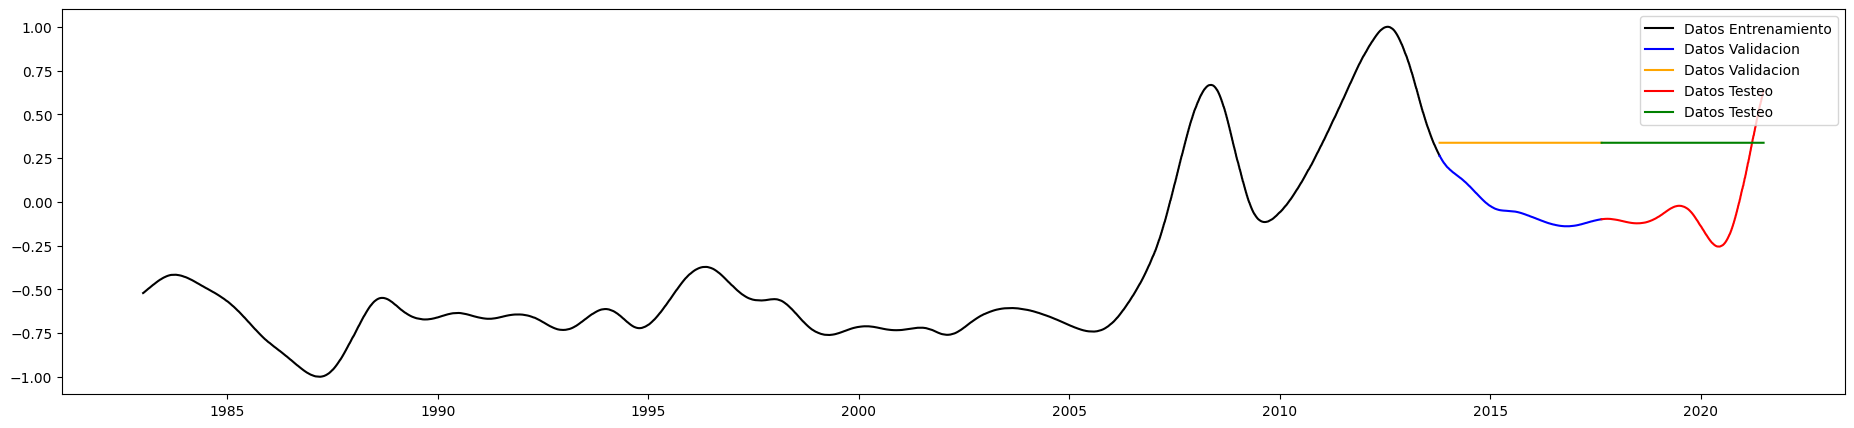

In [80]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [81]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [85]:
datos_emd = modo_1.Precio_Cierre + modo_2.Precio_Cierre +modo_3.Precio_Cierre + modo_4.Precio_Cierre + modo_5.Precio_Cierre + residuo.Precio_Cierre
datos_emd = datos_emd.to_frame()

In [86]:

validacion = prediccion_validacion_m1 + prediccion_validacion_m2 + prediccion_validacion_m3 +prediccion_validacion_m4 + prediccion_validacion_m5 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m1 + prediccion_testeo_m2 + prediccion_testeo_m3 + prediccion_testeo_m4 + prediccion_testeo_m5 + prediccion_testeo_residuo

In [87]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [89]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre)
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 101.81728102563986 
el error absoluto medio del modelo es: 95.44249859439641 
Error porcentual absoluto medio del modelo es: 0.18877905442401594


In [90]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( testeo,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 107.9687542260226 
el error absoluto medio del modelo es: 103.30444647919165 
Error porcentual absoluto medio del modelo es: 0.20432575727904118


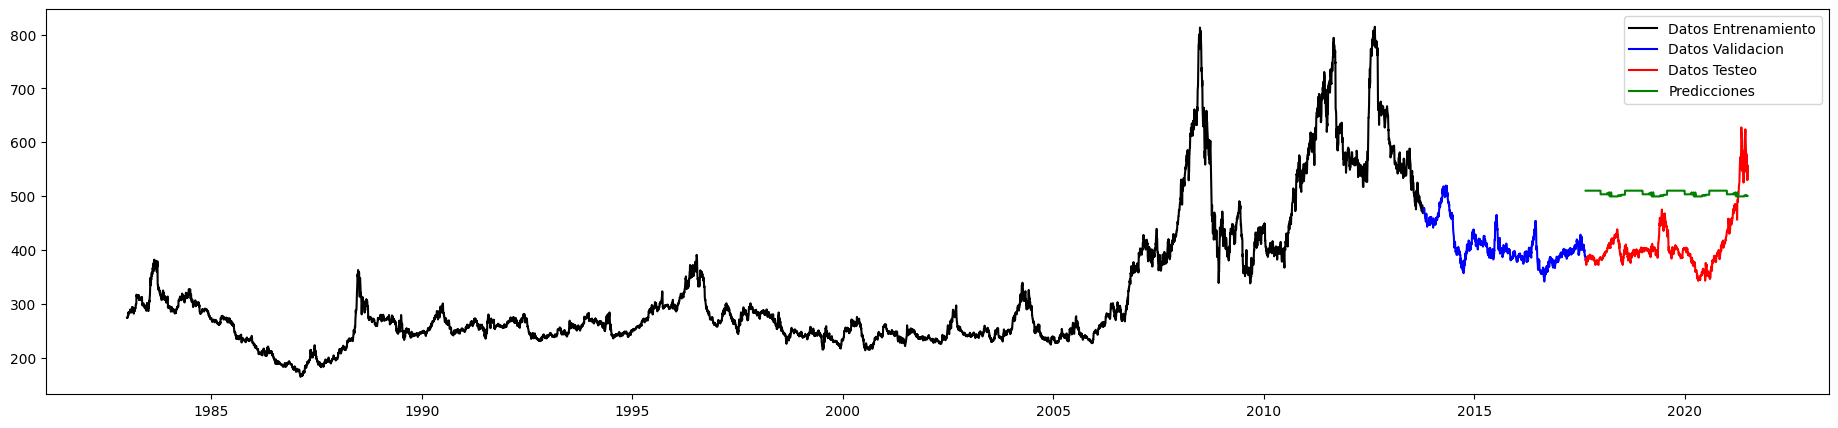

In [91]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

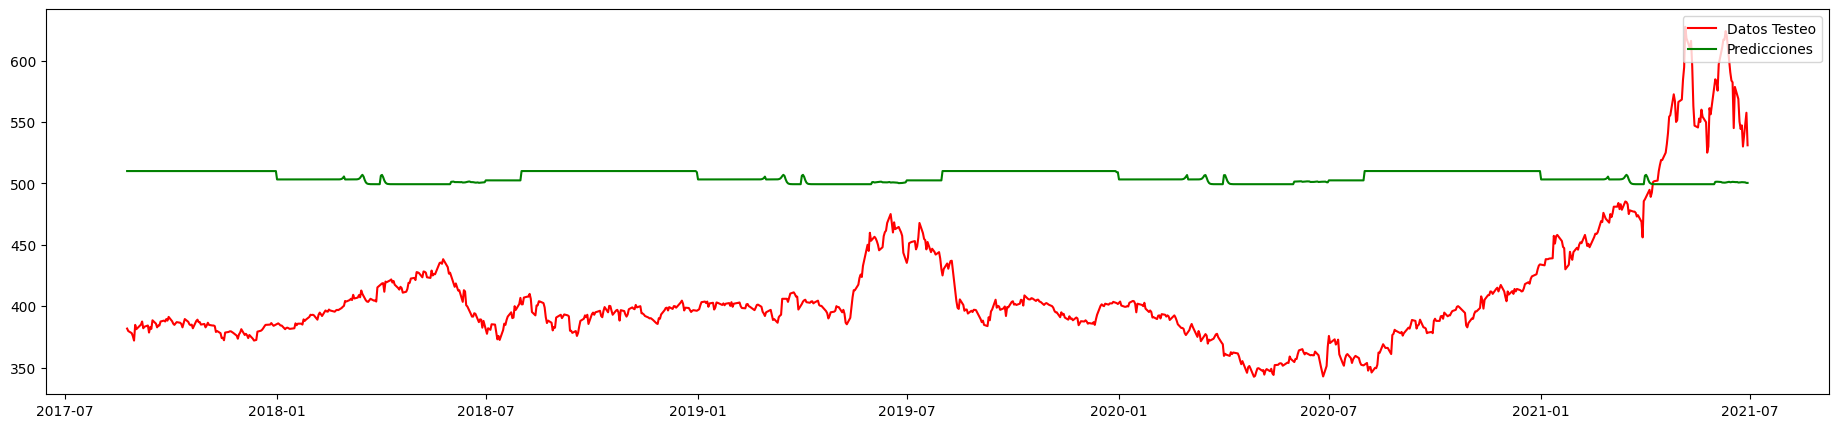

In [92]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()